In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
import time, sys  
import random

In [2]:
%matplotlib inline
#%%capture
#!pip install ipython-autotime
%reload_ext autotime

time: 175 µs


In [3]:
# code settings
nx_lf     = 32
nx_hf     = 256
samples   = 100
eps       = 1e-6
save_plot = 0 # toggle flag to save figures
transf    = 0 # toggle flag to apply coordinate transform

time: 327 µs


In [4]:
# burgers' solver functions

# define initial condition   
def ic(x, sharpen):
    xcenter = 0.5   # location of the gaussian center
    phi_ic = np.exp(-sharpen*(x - xcenter)**2) 
    return phi_ic

# set initial condition   
def initialize(nno,x,phi):
    for i in range(nno):
        phi[i]=ic(x[i], sharpen)

# compute errors
def compute_exact(nno,time,x,phi_exact):
    time_shift = time
    if periodic and time*u > L:
        a = divmod(time,L/u)
        time_shift = a[1]
    for i in range(nno):
        phi_exact[i]=ic(x[i]-u*time_shift, sharpen)

# First Order Upwind
def update_upwind(nno,dx,dt,phi):
    phi_old = phi.copy() 
    for i in range(1, nno-1):
        im = i-1
        #phi[i] = phi_old[i]-0.5*dt/dx*(phi_old[i]**2 - phi_old[im]**2) # conservative
        phi[i] = phi_old[i]-phi_old[i]*dt/dx*(phi_old[i] - phi_old[im])  

# Lax Wendroff
def update_laxwendroff(nno,dx,dt,phi):
    phi_old = phi.copy() 
    for i in range(1, nno-1):
        im = i-1
        ip = i+1
        phi[i] = phi_old[i]-0.5*phi_old[i]*dt/dx*((phi_old[ip]-phi_old[im])
                  -phi_old[i]*dt/dx*(-2.*phi_old[i]+phi_old[im]+phi_old[ip]))

# set boundary condition  
def bc(nno,x,phi,time):
    if (periodic):
        phi[0]=phi[nno-2] #apply periodicity @ x=0
        phi[nno-1]=phi[1] #apply periodicity @ x=L
    else:
        phi[0]=ic(x[0]-np.max(phi)*time, sharpen) #ncross the right boundary
        #phi[nno-1]=phi[nno-2] #zero-gradient?
        phi[nno-1]=ic(x[nno-1]-np.max(phi)*time, sharpen) #cross the right boundary

# solve the PDE
def solve(nno,scheme="upwind",plot=0):  
    #by default use upwind and plot solution
    start = time.time() 
    dx = L / (nno-1)    # spacing of the nodes
    x = np.linspace(0,L,nno)  #grid generation
    phi = np.zeros(nno)  
    phi_exact = np.zeros(nno)  
    initialize(nno,x,phi) #initialize
    mytime = 0
    nts = 0
    dt = cfl*dx/np.max(phi)
    while mytime < T:  #integrate up to time T
        bc(nno,x,phi,mytime)
        nts = nts + 1
        mytime = mytime + dt  
        # update the solution with a finite difference scheme (explicit)
        if scheme == "upwind": 
            update_upwind(nno,dx,dt,phi)
        elif scheme == "laxwendroff":
            update_laxwendroff(nno,dx,dt,phi)
    # compare the solution with the exact and compute the L2 norm
    compute_exact(nno,mytime,x,phi_exact)
    end = time.time()

    return phi 

time: 1.37 ms


In [5]:
# compute LF solution (and HF for reference)
random.seed(42) # fix seed for np.random
sli.seed(43)    # fix seed for svd/id algorithm

time: 1.26 ms


In [6]:
s = np.random.uniform(5, 25, samples)
phi_lf = np.zeros((nx_lf, samples))
phi_hf = np.zeros((nx_hf, samples))

u = 1.0         
L = 2.0        
T = 1.0
cfl = 0.1      
periodic = 1    # periodicity on/off 
x = np.linspace(0,L,samples)

for _ in range(len(s)):
    sharpen = s[_]
    phi = np.zeros(samples)  
    
    for i in range(samples):
        phi[i]=ic(x[i], sharpen)
    
    phi_lf[:,_] = solve(nx_lf,"upwind",0)
    phi_hf[:,_] = solve(nx_hf,"upwind",0)

time: 30 s


In [7]:
np.save('LF', phi_lf)
np.save('HF', phi_hf)

time: 2.72 ms


In [8]:
# coordinate transform
def transform(p):
    """Transform problem into a domain that fixes the shock for all realisations"""
    grad_phi = np.zeros((p.shape[0]-1,p.shape[1]))

    for j in range(p.shape[1]):
        for i in range(p.shape[0]-1):
            grad_phi[i,j] = p[i,j] - p[i+1,j]

    shock_loc = np.zeros(p.shape[1])

    for _ in range(p.shape[1]):
        shock_loc[_] = np.argmax(grad_phi[:,_]) # get shock location

    shift_phi = np.zeros(np.shape(p))

    for _ in range(p.shape[1]):
        shift_phi[:,_] = np.roll(p[:,_], int(p.shape[0]//2 - shock_loc[_]))
    
    return shift_phi, shock_loc

time: 477 µs


In [9]:
if transf:
    phi_lf, sloc_lf = transform(phi_lf)
    phi_hf, sloc_hf = transform(phi_hf)
    np.save('LFT', phi_lf)
A = phi_lf

time: 292 µs


In [10]:
k, idx, proj = sli.interp_decomp(A, eps)

print("rank =",k , "of", samples)
print("idx = ",idx.shape)
print("proj = ",proj.shape)

rank = 16 of 100
idx =  (100,)
proj =  (16, 84)
time: 34.6 ms


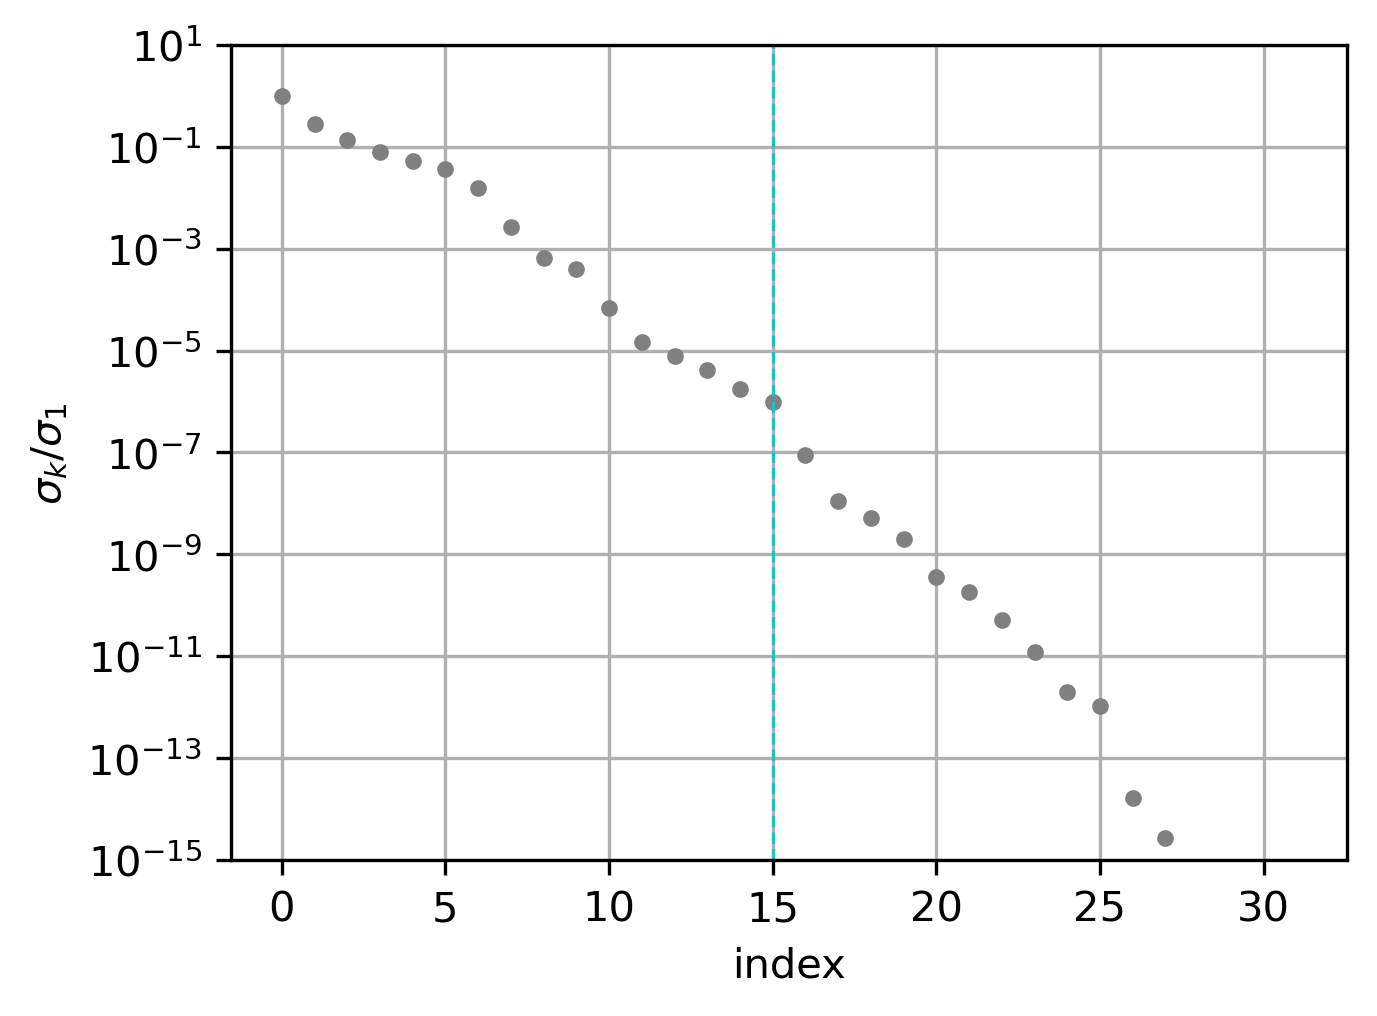

time: 572 ms


In [11]:
# compute singular value decomposition to check eps choice
u, sv, vh = np.linalg.svd(A, full_matrices=True)
del u, vh

fig1 = plt.figure(figsize=[6.4*.75, 4.8*.75],dpi=300)
ax = fig1.add_subplot(1,1,1)
ax.semilogy(sv/sv[0], 'r.', color='grey')
#ax.set_title('Singular values cutoff')
ax.set_ylabel('$\sigma_k/\sigma_1$')
ax.set_xlabel('index')
ax.axvline([k-1], c='darkturquoise', lw=0.75, ls='--')  
ax.set_ylim([1e-15,1e1])
ax.grid('on')
if save_plot:
    plt.savefig("./figures/sv.png",bbox_inches='tight')

In [12]:
B = sli.reconstruct_skel_matrix(A, k, idx)
P = sli.reconstruct_interp_matrix(idx, proj)
C = sli.reconstruct_matrix_from_id(B, idx, proj) # C = B*P
print("B = ",B.shape)
print("P = ",P.shape)
print("C = ",C.shape)

diff = sli.estimate_spectral_norm_diff(A, C)
print("Frob Error = ",np.linalg.norm(A-C))
print("Spectral Norm of Difference = ",diff)

B =  (32, 16)
P =  (16, 100)
C =  (32, 100)
Frob Error =  3.6383473816853583e-06
Spectral Norm of Difference =  3.5230488050717626e-06
time: 4.56 ms


In [13]:
phi_bf = np.dot(phi_hf[:,idx[0:k]],P) # reconstructed high-fidelity solution
print(np.shape(phi_bf))

(256, 100)
time: 2.18 ms


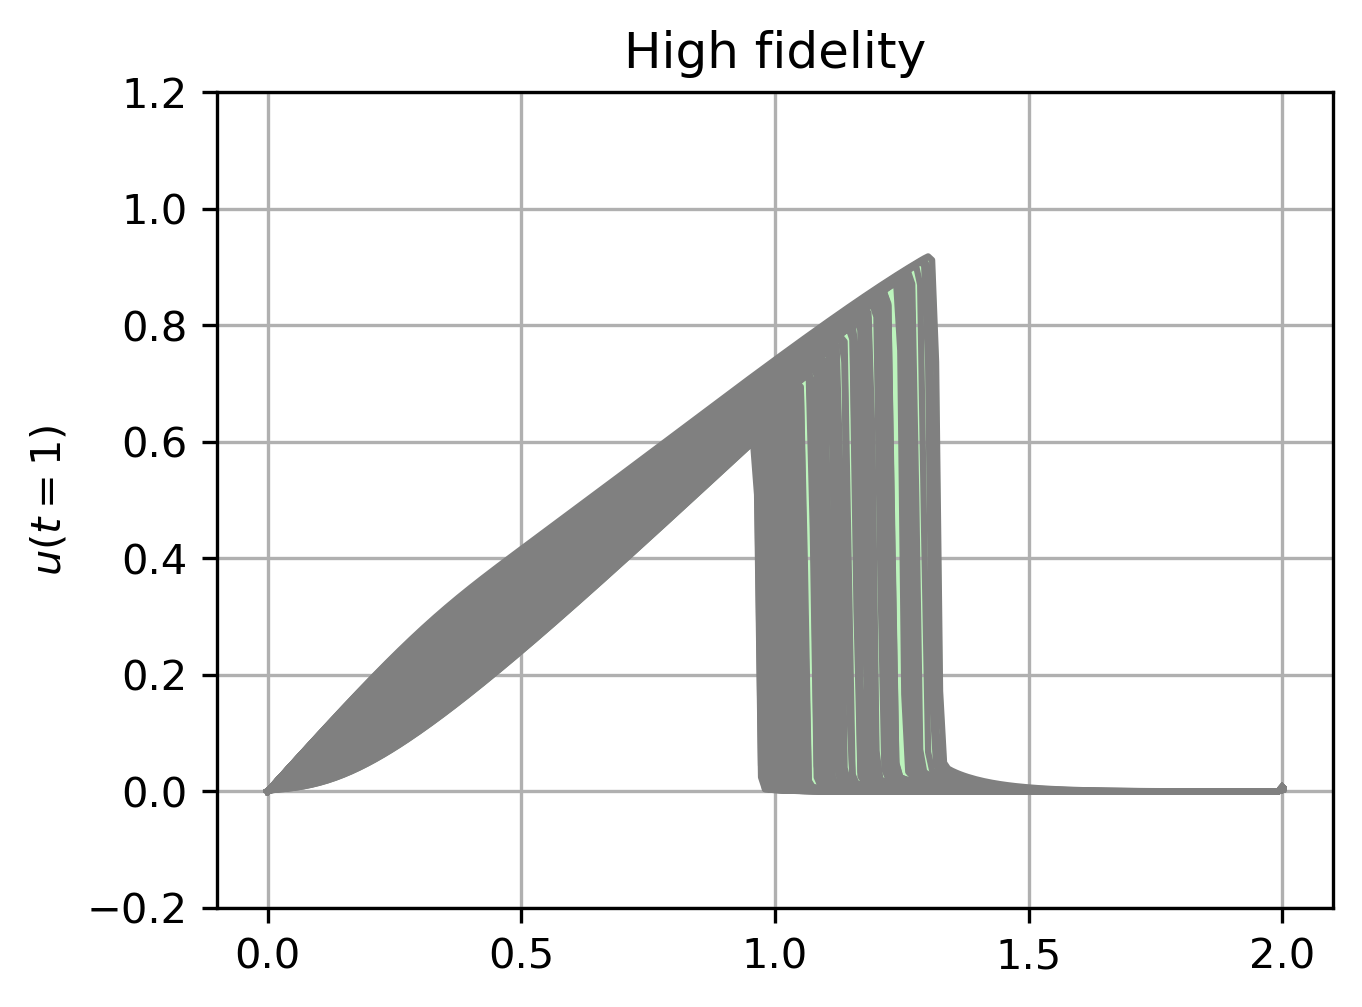

time: 267 ms


In [14]:
# plot HF results

X = np.linspace(0,L,nx_hf)
# generate uncertainty envelope
low_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    low_bnd[_] = min(phi_hf[_,:])
    
upp_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    upp_bnd[_] = max(phi_hf[_,:])

fig2 = plt.figure(figsize=[6.4*.75, 4.8*.75],dpi=300)
ax = fig2.add_subplot(1,1,1)
#ax.plot(X,phi_hf[:,idx[0:k]], '-', color='grey')
ax.plot(X,phi_hf, '-', color='grey')
#ax.plot(X,phi_check, '-', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_ylim([-.2,1.2])
ax.grid('on')
ax.set_title('High fidelity')
ax.fill_between(X,low_bnd,upp_bnd,color='lightgreen',alpha=0.6)      # uq bounds

if save_plot:
    plt.savefig("./figures/hf.png",bbox_inches='tight')

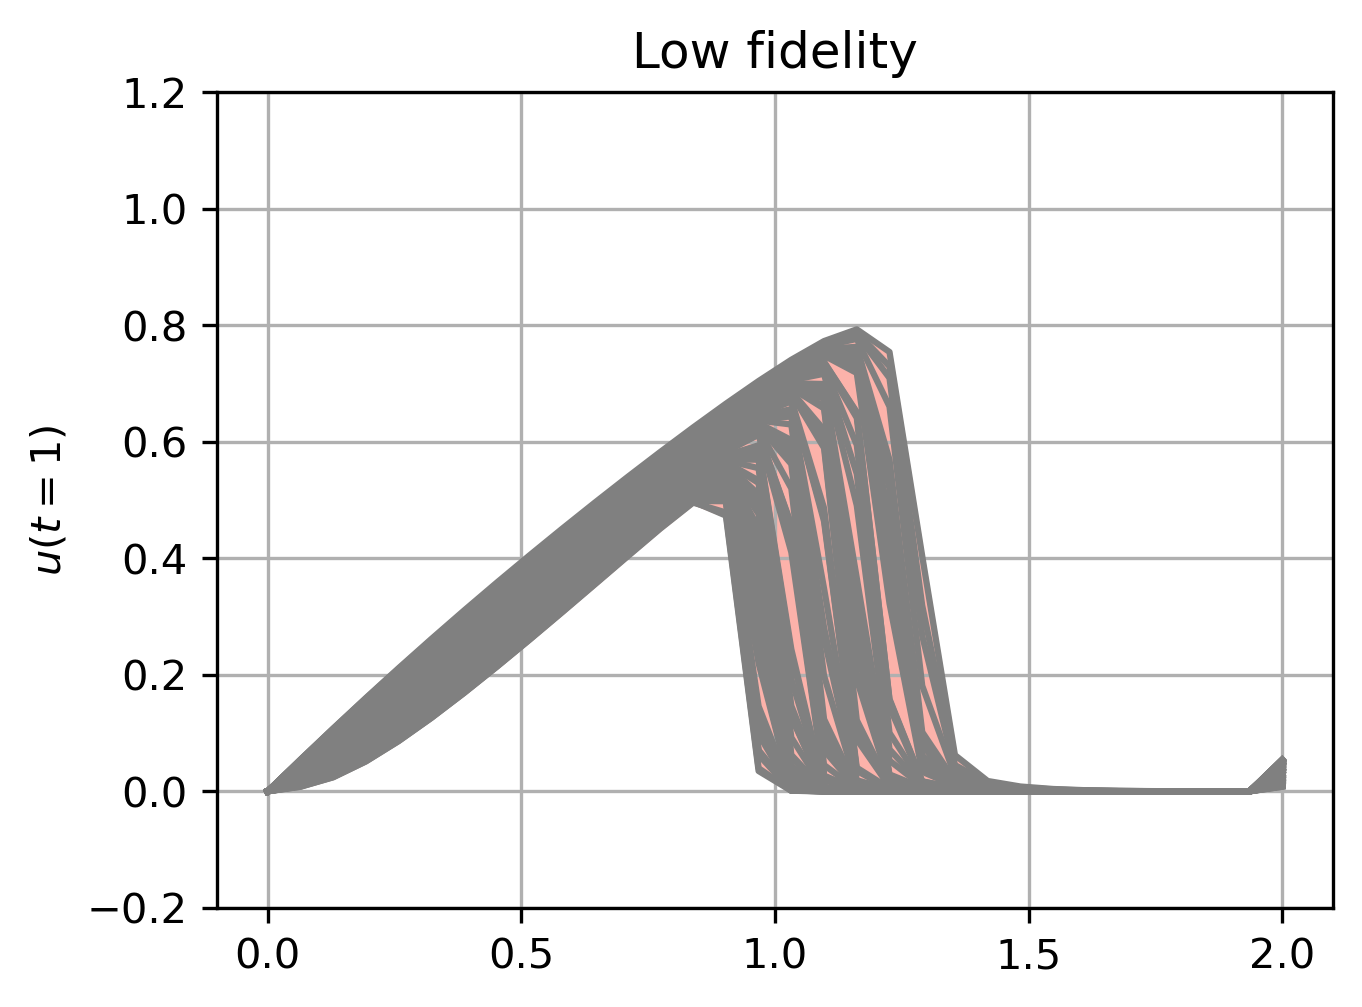

time: 244 ms


In [15]:
# plot LF results
X = np.linspace(0,L,nx_lf)
# generate uncertainty envelope
low_bnd = np.zeros(nx_lf)
for _ in range(nx_lf):
    low_bnd[_] = min(phi_lf[_,:])
    
upp_bnd = np.zeros(nx_lf)
for _ in range(nx_lf):
    upp_bnd[_] = max(phi_lf[_,:])

fig3 = plt.figure(figsize=[6.4*.75, 4.8*.75],dpi=300)
ax = fig3.add_subplot(1,1,1)
ax.plot(X,phi_lf, '-', color='grey')
#ax.plot(X,phi_check_up, '-', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_ylim([-.2,1.2])
ax.set_title('Low fidelity')
ax.grid('on')
ax.fill_between(X,low_bnd,upp_bnd,color='salmon',alpha=0.6) 

if save_plot:
    plt.savefig("./figures/lf.png",bbox_inches='tight')

In [16]:
# back to original coordinates
if transf:
    shift_rcn = np.zeros(np.shape(phi_bf))

    for _ in range(phi_bf.shape[1]):
        #shift_rcn[:,_] = np.roll(phi_bf[:,_], int(phi_bf.shape[0]//2 + sloc_hf[_]))
        shift = int(phi_bf.shape[0]//2 + sloc_lf[_]*float(phi_hf.shape[0]/phi_lf.shape[0]))
        shift_rcn[:,_] = np.roll(phi_bf[:,_], shift)
 
    phi_bf = shift_rcn[:]

time: 697 µs


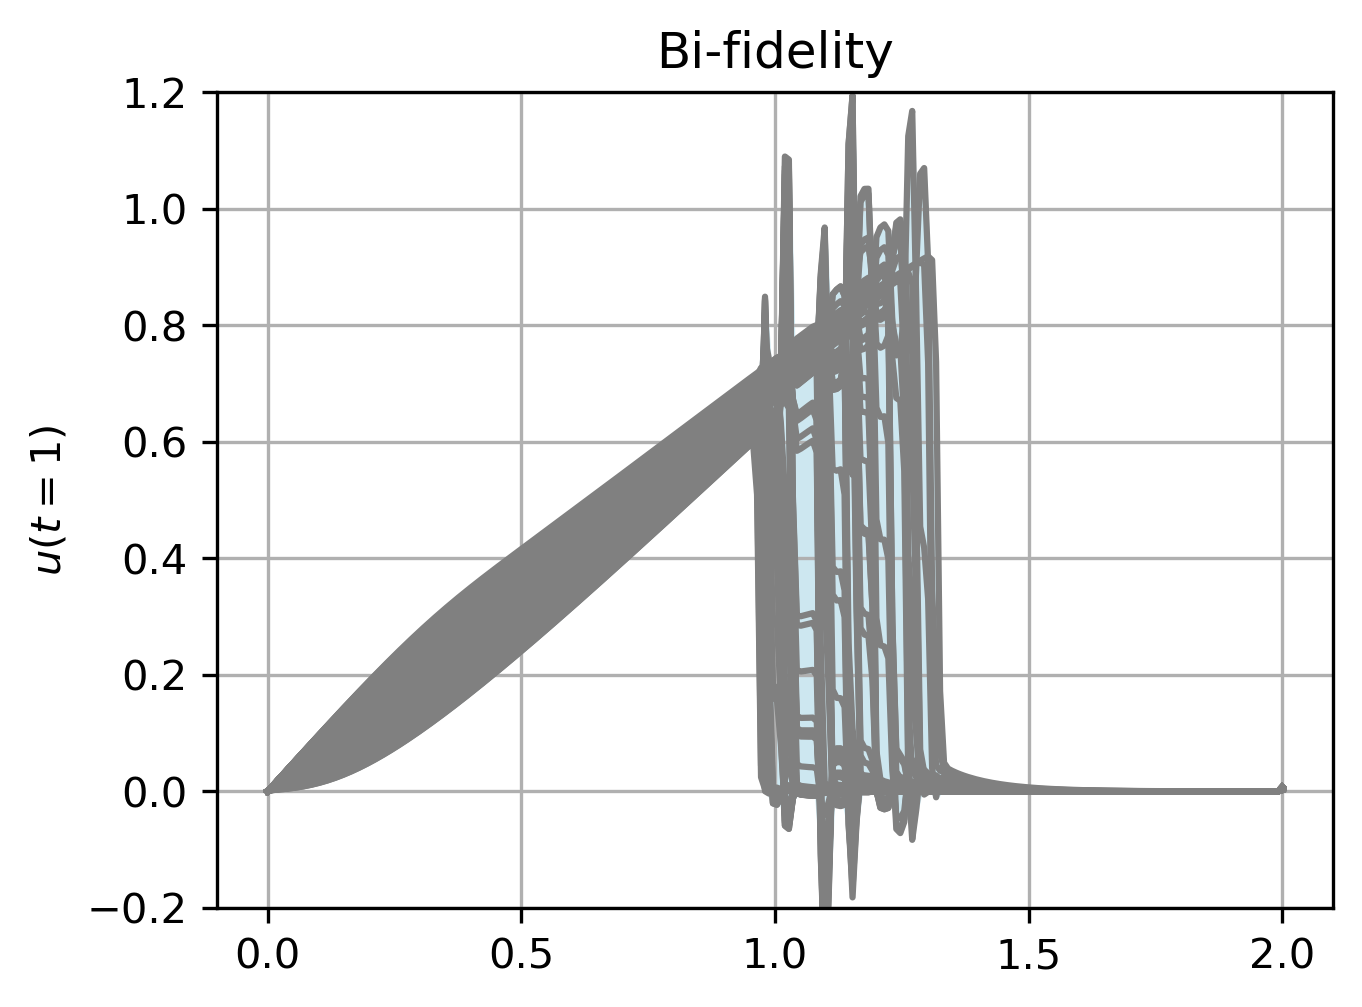

time: 281 ms


In [17]:
# plot BF results
X = np.linspace(0,L,nx_hf)

# generate uncertainty envelope
low_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    low_bnd[_] = min(phi_bf[_,:])
    
upp_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    upp_bnd[_] = max(phi_bf[_,:])

fig4 = plt.figure(figsize=[6.4*.75, 4.8*.75],dpi=300)
ax = fig4.add_subplot(1,1,1)
#ax.plot(X,phi_bf[:,idx[k:]], '-', color='grey')
ax.plot(X,phi_bf, '-', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_ylim([-.2,1.2])
ax.set_title('Bi-fidelity')
ax.grid('on')
ax.fill_between(X,low_bnd,upp_bnd,color='lightblue',alpha=0.6)      # uq bounds

if save_plot:
    plt.savefig("./figures/bf.png",bbox_inches='tight')

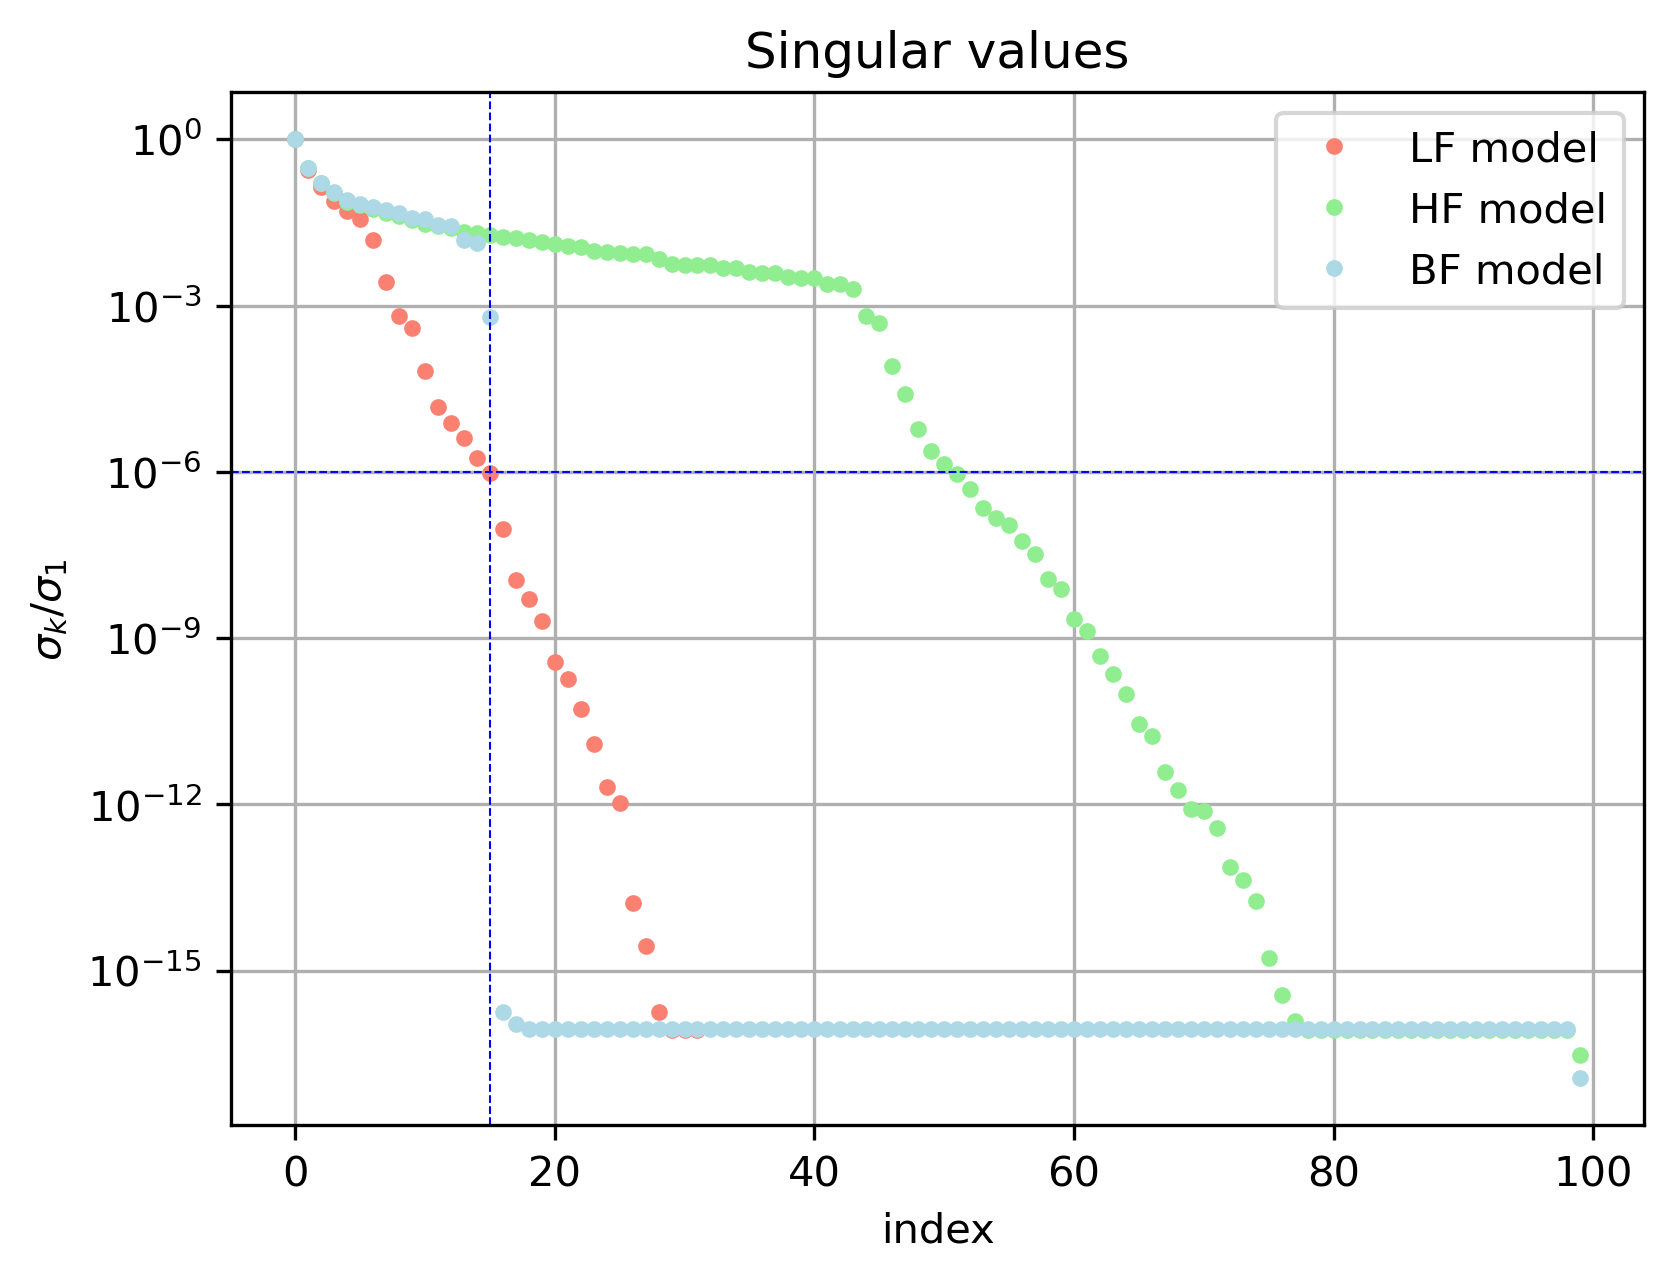

time: 406 ms


In [18]:
# compare singular values
_, sv_lf, _ = np.linalg.svd(phi_lf, full_matrices=True)
_, sv_hf, _ = np.linalg.svd(phi_hf, full_matrices=True)
_, sv_bf, _ = np.linalg.svd(phi_bf, full_matrices=True)

fig5 = plt.figure(figsize=[6.4*.95, 4.8*.95],dpi=300)
ax = fig5.add_subplot(1,1,1)
ax.semilogy(sv_lf/sv_lf[0], 'r.', color='salmon', label='LF model')
ax.semilogy(sv_hf/sv_hf[0], 'r.', color='lightgreen', label='HF model')
ax.semilogy(sv_bf/sv_bf[0], 'r.', color='lightblue', label='BF model')
ax.set_title('Singular values')
ax.set_ylabel('$\sigma_k/\sigma_1$')
ax.set_xlabel('index')
ax.legend()
ax.axvline([16-1], c='blue', lw=0.5, ls='--') 
ax.axhline([1e-6], c='blue', lw=0.5, ls='--')
ax.grid('on')
if save_plot:
    plt.savefig("./figures/sv-comp.png",bbox_inches='tight')